# Homework 2: CNN+RNN for video action recognition

Video classification for action recognition

Original code from https://github.com/aminullah6264/Pytorch-Action-Recognition/tree/master

## Dataset: UCF YouTube Action Data Set

Input is a video.

It contains 11 action categories: basketball shooting, biking/cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog.

https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

## Network: CNN + LSTM

1. Each frame in a video is an image. Apply a pre-trained Resnet encoder to each video frame separately. The result is a sequence of feature vectors.
2. Use the sequence of feature vectors as an input to an LSTM, configured as many-to-one. The result is a single feature vector.
3. Use a dense layer and softmax for the classification result (Class probabilities)

![Alt text](https://drive.google.com/uc?export=view&id=1__THInD1anw6dM0TSpyTz3DaB92QuKV0)



![Alt text](https://drive.google.com/uc?export=view&id=19YldS0u76k06iZAxk9FSKZsKvMkSj6a1)



In [1]:
# !pip install icecream
# !pip install torchinfo
# !pip install imageio
# !pip install -q git+https://github.com/tensorflow/docs
# !pip install torcheval
# !pip install gdown

!pip install -q icecream git+https://github.com/tensorflow/docs gdown

In [2]:
# Download the videos
!gdown --i 17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM

# !unzip -o /content/Videos_Youtube_val.zip
!unzip -o -q ./Videos_Youtube_val.zip

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM
From (redirected): https://drive.google.com/uc?id=17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM&confirm=t&uuid=c8515cd7-28ff-4ca9-a737-cf4a8d36f087
To: /kaggle/working/Videos_Youtube_val.zip
100%|█████████████████████████████████████████| 631M/631M [00:04<00:00, 150MB/s]


In [3]:
import gc
import os
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models

from torchinfo import summary

from torchmetrics.classification import (MulticlassAccuracy, 
                                         MulticlassF1Score)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imageio

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             ConfusionMatrixDisplay, 
                             f1_score)

from icecream import ic

from tensorflow_docs.vis import embed

from tqdm.auto import trange, tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%config InlineBackend.figure_format = "retina"

In [4]:
config = {
    'seed': 150,
    'train_batch_size': 64,
    'learning_rate': 1e-3,
    'epochs': 100,
    'patience': 10,
    'num_frames': 15,
    'use_convlstm': False,
    'hidden_size': 64,
    'num_layers': 1,
    'bidirectional': True, # only for LSTMClassifier
    'T_0': 10,
    'T_mult': 1,
}


## Reproducibility

In [5]:
# random.seed(150)
# np.random.seed(150)
# torch.manual_seed(150)


# random.seed(13)
# np.random.seed(13)
# torch.manual_seed(13)

def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(config['seed'])  

## Define experiment parameters

In [6]:
# Define the number of frames to extract features from (More frames = more temporal context)
# num_frames = 15
# use_convlstm = False

## Define the encoder

1. Get the resnet18 pretrained encoder from torchvision library. See the documentation https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
2. Remove the last layer (The final fully-connected layer responsible for image classification)

![Alt text](https://drive.google.com/uc?export=view&id=1db2Fws39VheIQmg3rqulwgNTwXZXiMdO)


![Alt text](https://drive.google.com/uc?export=view&id=1UNaMMWaebhEeCJuYGkVtwPQuFkKs_TXP)




## Encoder for LSTM:

![Alt text](https://drive.google.com/uc?export=view&id=1W3WOgF0uyCfqgJcVDDXrfuKfIL7SWPgx)



## Encoder for ConvLSTM (Before global average pooling):

![Alt text](https://drive.google.com/uc?export=view&id=1ZAKDLIqX8fdqCqPHa9OCCEJj5d69XDSj)


In [7]:
# Define the pre-processing steps for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the pre-trained ResNet50 model (Torchvision) (Imagenet weights)
resnet = models.resnet18(weights='DEFAULT').cuda()

if config['use_convlstm'] == False:
    resnet_layer_idx = -1
elif config['use_convlstm'] == True:
    resnet_layer_idx = -2

# Remove the last layer of the ResNet50 model to obtain the feature extractor
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:resnet_layer_idx])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


## Extract encoder features

In [8]:
def extract_encoder_features(data_dir):

    # Create an empty list to store the features and labels
    samples = []
    resnet.eval()
    
    # Loop over the videos in the dataset folder
    video_paths = []
    sample_label_name = []

    class_count = 0
    samples_per_class_count = 0
    samples_per_class_counts = []
    for label in tqdm(os.listdir(data_dir)):
        label_dir = os.path.join(data_dir, label)
        # print("label_dir", label_dir)

        class_count = class_count + 1
        samples_per_class_count = 0
        for sub_dir in os.listdir(label_dir):
            if sub_dir == 'Annotation':
                continue
            video_dir = os.path.join(label_dir, sub_dir)
            # print("video_dir", video_dir)
            for video_file in os.listdir(video_dir):
                samples_per_class_count = samples_per_class_count + 1
                video_path = os.path.join(video_dir, video_file)
                # print("video_path", video_path)
                cap = cv2.VideoCapture(video_path)

                frame_count = 0
                frames = []
                while True:
                    ret, frame = cap.read()
                    if ret:
                        frame_count += 1
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame = transform(frame).cuda()
                        frames.append(frame)
                        if frame_count == config['num_frames']:
                            break
                    else:
                        break
                cap.release()

                if len(frames) == config['num_frames']:

                    # Stack the frames into a tensor of shape (num_frames=15, 3, 224, 224)
                    frames_tensor = torch.stack(frames, dim=0) # frames_tensor shape: (num_frames=15, 3, 224, 224)
                    # Extract the features using the pre-trained ResNet50 model
                    with torch.no_grad():
                        features_tensor = resnet_feat(frames_tensor) # features_tensor shape: (num_frames=15, feature_size=512, 7, 7) if use_convlstm else (num_frames=15, feature_size=512, 1, 1)
                        # print("features_tensor.shape", features_tensor.shape)
                    # Flatten the features tensor
                    if config['use_convlstm'] == False:
                        features_tensor = torch.flatten(features_tensor, start_dim=1) # features_tensor shape: (num_frames=15, feature_size=512)

                    # Convert the features tensor to a numpy array
                    features = features_tensor.cpu().numpy()
                    # Append the features and label to the samples list
                    samples.append((features, label))
                    video_paths.append(video_path)
                    sample_label_name.append(label)
        print(f"Class: {label}, count: {samples_per_class_count}")
        samples_per_class_counts.append(samples_per_class_count)
        
    return samples, video_paths, sample_label_name, samples_per_class_counts

In [9]:
# Define the file path to your dataset
data_dir_train = './Videos/Train'
data_dir_test = './Videos/Test'
data_dir_validation = './Videos/Validation'

In [10]:
%%time

train_samples, _, _, count_per_class_train = extract_encoder_features(data_dir_train)

  0%|          | 0/11 [00:00<?, ?it/s]

Class: soccer_juggling, count: 94
Class: volleyball_spiking, count: 80
Class: swing, count: 148
Class: basketball, count: 82
Class: diving, count: 107
Class: trampoline_jumping, count: 78
Class: tennis_swing, count: 112
Class: walking, count: 80
Class: horse_riding, count: 119
Class: biking, count: 86
Class: golf_swing, count: 81
CPU times: user 1min 36s, sys: 2.55 s, total: 1min 39s
Wall time: 48.5 s


In [11]:
%%time

validation_samples, _, _, count_per_class_validation = extract_encoder_features(data_dir_validation)

  0%|          | 0/11 [00:00<?, ?it/s]

Class: soccer_juggling, count: 29
Class: volleyball_spiking, count: 16
Class: swing, count: 18
Class: basketball, count: 24
Class: diving, count: 19
Class: trampoline_jumping, count: 19
Class: tennis_swing, count: 25
Class: walking, count: 21
Class: horse_riding, count: 29
Class: biking, count: 26
Class: golf_swing, count: 27
CPU times: user 21.4 s, sys: 105 ms, total: 21.5 s
Wall time: 10.8 s


In [12]:
%%time

test_samples, video_paths_test, sample_label_name, count_per_class_test = extract_encoder_features(data_dir_test)

  0%|          | 0/11 [00:00<?, ?it/s]

Class: soccer_juggling, count: 33
Class: volleyball_spiking, count: 20
Class: swing, count: 25
Class: basketball, count: 35
Class: diving, count: 30
Class: trampoline_jumping, count: 22
Class: tennis_swing, count: 30
Class: walking, count: 22
Class: horse_riding, count: 50
Class: biking, count: 33
Class: golf_swing, count: 34
CPU times: user 28.4 s, sys: 148 ms, total: 28.6 s
Wall time: 14.3 s


In [13]:
count_per_class_train

[94, 80, 148, 82, 107, 78, 112, 80, 119, 86, 81]

In [14]:
count_per_class_validation

[29, 16, 18, 24, 19, 19, 25, 21, 29, 26, 27]

In [15]:
count_per_class_test

[33, 20, 25, 35, 30, 22, 30, 22, 50, 33, 34]

In [16]:
len(video_paths_test)

332

## Convert data to Numpy arrays

In [17]:
len(train_samples)

1064

In [18]:
# Separate the features and labels into separate arrays for training and testing sets
train_features, train_labels = zip(*train_samples)
validation_features, validation_labels = zip(*validation_samples)
test_features, test_labels = zip(*test_samples)

# Convert the labels to numerical labels using a LabelEncoder
le = LabelEncoder()
train_numerical_labels = le.fit_transform(train_labels)
validation_numerical_labels = le.fit_transform(validation_labels)
test_numerical_labels = le.fit_transform(test_labels)
# Convert the features and labels arrays to numpy arrays
train_features = np.array(train_features)
train_labels = train_numerical_labels
validation_features = np.array(validation_features)
validation_labels = validation_numerical_labels
test_features = np.array(test_features)
test_labels = test_numerical_labels

# Print the shapes of the features and labels arrays
print("Train Features shape:", train_features.shape)
print("Train Labels shape:", train_labels.shape)
print("Validation Features shape:", validation_features.shape)
print("Validation Labels shape:", validation_labels.shape)
print("Test Features shape:", test_features.shape)
print("Test Labels shape:", test_labels.shape)


# Save the features and labels to numpy arrays
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('validation_features.npy', validation_features)
np.save('validation_labels.npy', validation_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

Train Features shape: (1064, 15, 512)
Train Labels shape: (1064,)
Validation Features shape: (253, 15, 512)
Validation Labels shape: (253,)
Test Features shape: (332, 15, 512)
Test Labels shape: (332,)


In [19]:
target_names = le.inverse_transform(np.array([0,1,2,3,4,5,6,7,8,9,10]))
target_names

array(['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding',
       'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping',
       'volleyball_spiking', 'walking'], dtype='<U18')

## Convert data to Torch tensors

In [20]:
# Load the features and labels from numpy arrays
train_features = torch.from_numpy(np.load('train_features.npy')).float()
train_labels = torch.from_numpy(np.load('train_labels.npy'))#.long()
idx = np.random.permutation(len(train_features))
train_features, train_labels = train_features[idx], train_labels[idx]

validation_features = torch.from_numpy(np.load('validation_features.npy')).float()
validation_labels = torch.from_numpy(np.load('validation_labels.npy'))#.long()
test_features = torch.from_numpy(np.load('test_features.npy')).float()
test_labels = torch.from_numpy(np.load('test_labels.npy'))#.long()

train_features.shape, train_labels.shape, validation_features.shape, validation_labels.shape

(torch.Size([1064, 15, 512]),
 torch.Size([1064]),
 torch.Size([253, 15, 512]),
 torch.Size([253]))

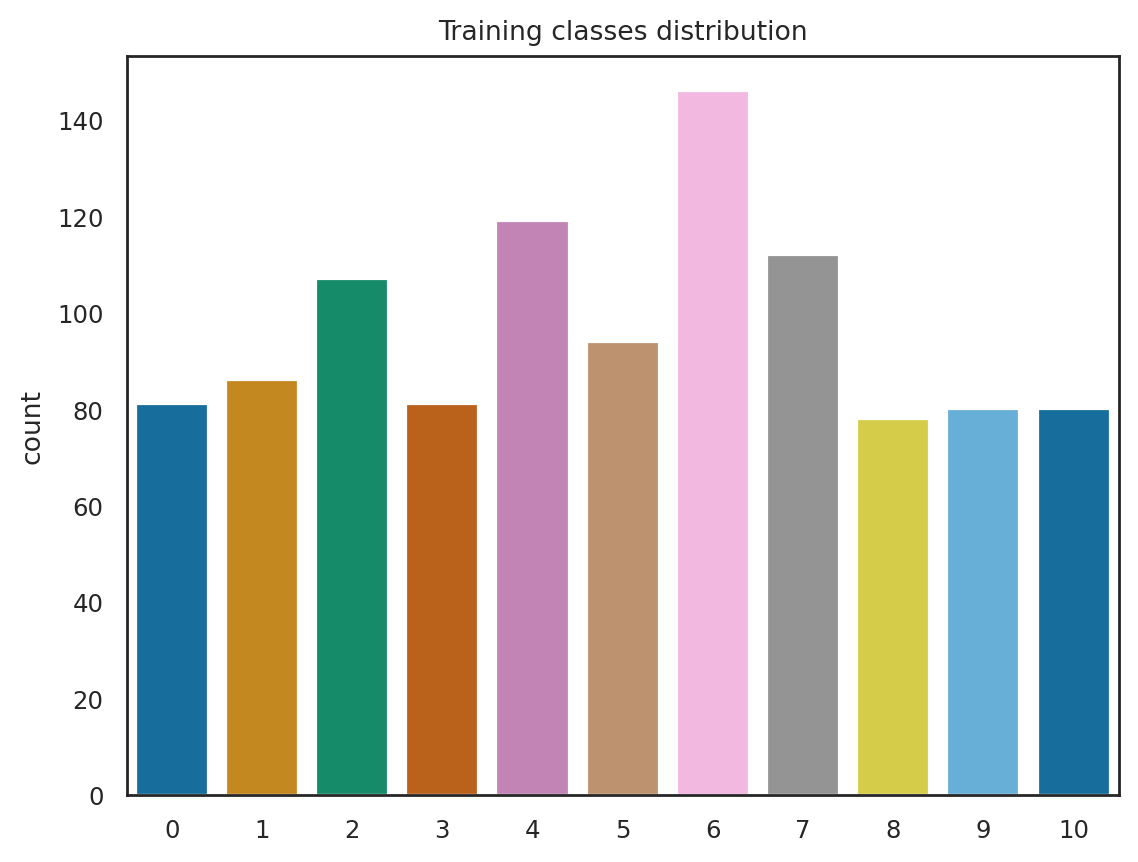

In [21]:
sns.set(context='paper', style='white')
sns.countplot(x=train_labels.numpy(), palette='colorblind')
plt.title('Training classes distribution');

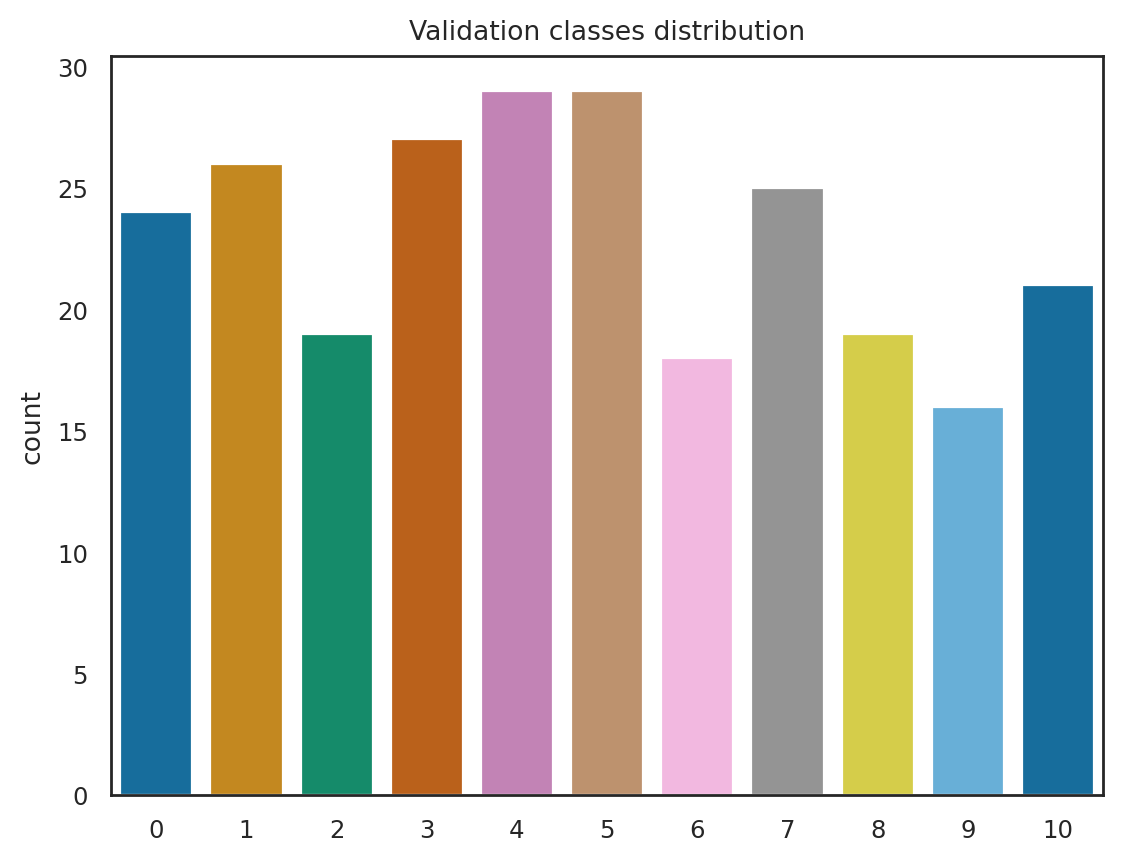

In [22]:
sns.countplot(x=validation_labels.numpy(), palette='colorblind')
plt.title('Validation classes distribution');

## Create DataLoader

In [23]:

# Define separate datasets for training and validation
class CustomDataset(Dataset):
    def __init__(self, input, reference, transform=None, transform_reference=None):
        self.input = input
        self.reference = reference
        self.transform = transform
        self.transform_reference = transform_reference
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        image = self.input[idx]
        label = self.reference[idx]
        # Apply the transform to the image

        return image, label

# Create training and validation dataset instances
train_dataset = CustomDataset(train_features, train_labels, transform=None, transform_reference=None)
val_dataset = CustomDataset(validation_features, validation_labels, transform=None, transform_reference=None)
test_dataset = CustomDataset(test_features, test_labels, transform=None, transform_reference=None)


# Create separate DataLoaders for training and validation
# train_batch_size = 16 # Adjust batch_size as needed
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data


## Define the LSTM model

See LSTM documentation https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

![](https://drive.google.com/uc?export=view&id=1wimmf6Gt-hU1X4dMCXmVuANJAN5FM2mA)


![](https://drive.google.com/uc?export=view&id=1IFfxsTatjutdQEsiggtBGNbVL-hvZYFc)


## ConvLSTM definition.
Taken from https://github.com/ndrplz/ConvLSTM_pytorch/tree/master

In [24]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [25]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        linear_filter_size = hidden_size*2 if bidirectional==True else hidden_size
        self.fc = nn.Linear(linear_filter_size, num_classes) # *2 to account for bidirectional LSTM

    def forward(self, x):
        # x shape: (batch_size=1, num_frames=15, feature_size = 512)

        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x) # out shape: (batch_size=1, num_frames=15, feature_size = 128*2)

        # Get hidden state of the last time step
        out = out[:, -1, :] # out shape: (batch_size=1, feature_size = 128*2)
        out = self.fc(out) # out shape: (batch_size=1, feature_size = 11)
        out = nn.functional.softmax(out, dim=1) # out shape: (batch_size=1, feature_size = 11)
        return out

In [26]:

class ConvLSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.convlstm = ConvLSTM(input_dim=512,
                 hidden_dim=self.hidden_size,
                 kernel_size=(3,3),
                 num_layers=num_layers,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)
        self.fc = nn.Linear(hidden_size, num_classes) # *2 to account for bidirectional LSTM
        self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((1,1))
    def forward(self, x):
        # x shape: (batch_size=1, num_frames=15, feature_size = 512, h=7, w=7)

        out_sequence, _ = self.convlstm(x)
        out_sequence = out_sequence[0]# out_sequence: list of 15 frames, each frame of shape: (batch_size=1, num_frames=15 feature_size = 64, h=7, w=7)

        # Get hidden state of the last time step
        out = out_sequence[:, -1, ...] # out shape: (batch_size=1, feature_size = 64, h=7, w=7)

        out = self.adaptive_avg_pool2d(out) # x shape: (batch_size=1, feature_size = 64, h=1, w=1)

        out = torch.flatten(out, start_dim=1) # x shape: (batch_size=1, num_frames=15, feature_size = 64)

        out = self.fc(out) # out shape: (batch_size=1, feature_size = 11)
        out = nn.functional.softmax(out, dim=1) # out shape: (batch_size=1, feature_size = 11)
        return out



## Define model parameters

In [27]:
# # Define the LSTM parameters
# input_size = train_features.shape[-1]
# num_classes = len(np.unique(train_labels))
# print(num_classes)

# # Define model parameters
# hidden_size = 128
# num_layers = 2

# # Only for LSTMClassifier
# bidirectional = False

config['input_size'] = train_features.shape[-1]
config['num_classes'] = len(np.unique(train_labels))

config

{'seed': 150,
 'train_batch_size': 64,
 'learning_rate': 0.001,
 'epochs': 100,
 'patience': 10,
 'num_frames': 15,
 'use_convlstm': False,
 'hidden_size': 64,
 'num_layers': 1,
 'bidirectional': True,
 'T_0': 10,
 'T_mult': 1,
 'input_size': 512,
 'num_classes': 11}

## Define the LSTM model

In [28]:
# Instantiate the LSTM model
if config['use_convlstm'] == False:
    model = LSTMClassifier(
        input_size=config['input_size'], 
        hidden_size=config['hidden_size'], 
        num_classes=config['num_classes'], 
        num_layers=config['num_layers'], 
        bidirectional=config['bidirectional']
    )
    model.to(device)
    
    print(summary(model, 
                  input_size=(config['train_batch_size'], 15, 512), 
                  col_names=('output_size', 'num_params', 'trainable'), 
                  device='cpu'))
    
elif config['use_convlstm'] == True:
    model = ConvLSTMClassifier(
        hidden_size=config['input_size'], 
        num_classes=config['num_classes'], 
        num_layers=config['num_layers']
    )
    model.to(device)
        
    print(summary(model, 
                  input_size=(config['train_batch_size'], 15, 512), 
                  col_names=('output_size', 'num_params', 'trainable'), 
                  device='cpu'))

Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
LSTMClassifier                           [64, 11]                  --                        True
├─LSTM: 1-1                              [64, 15, 128]             295,936                   True
├─Linear: 1-2                            [64, 11]                  1,419                     True
Total params: 297,355
Trainable params: 297,355
Non-trainable params: 0
Total mult-adds (M): 284.19
Input size (MB): 1.97
Forward/backward pass size (MB): 0.99
Params size (MB): 1.19
Estimated Total Size (MB): 4.14


In [29]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:8.5f} --> {val_loss:8.5f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [30]:
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")

In [31]:
print_model_parameters(model)

The Model has 0.30M parameters


## Train

It is suggested to follow the training example from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

Use early stopping as in the aforementioned example

In [32]:
# You: Define the loss function and optimizer
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.CrossEntropyLoss(reduction='mean')

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=config['T_0'], T_mult=config['T_mult'],
)

In [33]:
# You: Add your training logic here

def train_fn(model, dataloader, optimizer, criterion, epoch):

    scaler = torch.cuda.amp.GradScaler()  # deal with out of memory

    model.train()

    acc_metric = MulticlassAccuracy(num_classes=config['num_classes'], average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=config['num_classes'], average='macro').to(device)

    running_loss = 0.
    for ii, (images, labels) in enumerate(tqdm(dataloader, leave=False)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Update scheduler
        if scheduler is not None:
            scheduler.step(epoch + ii / len(dataloader))

        # Update metrics
        running_loss += loss.item()
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

        torch.cuda.empty_cache()
        _ = gc.collect()

    # Compute metrics
    acc = acc_metric.compute()
    acc_metric.reset()

    f1 = f1_metric.compute()
    f1_metric.reset()

    return running_loss / len(dataloader), acc, f1


In [34]:
@torch.no_grad()
def valid_fn(model, dataloader, criterion):

    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=config['num_classes'], average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=config['num_classes'], average='macro').to(device)

    running_loss = 0.
    for images, labels in tqdm(dataloader, leave=False):
        images = images.to(device)
        labels = labels.to(device)             

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(images)            
            loss = criterion(outputs, labels)

        # Compute metrics
        running_loss += loss.item()
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

        torch.cuda.empty_cache()
        _ = gc.collect()
    
    # Compute metrics
    acc = acc_metric.compute()
    acc_metric.reset()

    f1 = f1_metric.compute()
    f1_metric.reset()

    return running_loss / len(dataloader), acc, f1

In [35]:
%%time

t0 = time.time()

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=config['patience'], verbose=True)
history = {
    'train_loss': [],
    'train_acc' : [],
    'train_f1'  : [],
    'valid_loss': [],
    'valid_acc' : [],
    'valid_f1'  : []
}
for epoch in trange(config['epochs']):

    train_loss, train_acc, train_f1 = train_fn(model, train_loader, optimizer, criterion, epoch)
    valid_loss, valid_acc, valid_f1 = valid_fn(model, valid_loader, criterion)

    print(f"Epoch: {epoch + 1:>03}, Learning Rate: {optimizer.param_groups[0]['lr']}")
    print(f'train loss: {train_loss:8.5f} | train acc: {train_acc:8.5f} | train f1 score: {train_f1:8.5f} | '
          f'val loss: {valid_loss:8.5f} | val acc: {valid_acc:8.5f} | val f1 score: {valid_f1:8.5f}',)

    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    history['train_loss'].append(train_loss)
    history['train_acc' ].append(train_acc.detach().cpu())
    history['train_f1'  ].append(train_f1.detach().cpu())
    history['valid_loss'].append(valid_loss)
    history['valid_acc' ].append(valid_acc.detach().cpu())
    history['valid_f1'  ].append(valid_f1.detach().cpu())

    if early_stopping.early_stop:
        print("Early stopping")
        break

print(f"\nExecution time: {time.time() - t0:.5f}\n")

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 001, Learning Rate: 0.0009783022097502204
train loss:  2.34338 | train acc:  0.26054 | train f1 score:  0.19028 | val loss:  2.29317 | val acc:  0.36392 | val f1 score:  0.22019
Validation loss decreased (     inf -->  2.29317).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 002, Learning Rate: 0.0009098702414536106
train loss:  2.15927 | train acc:  0.41420 | train f1 score:  0.32607 | val loss:  2.15890 | val acc:  0.49756 | val f1 score:  0.38107
Validation loss decreased ( 2.29317 -->  2.15890).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 003, Learning Rate: 0.0008013173181896282
train loss:  2.01975 | train acc:  0.55610 | train f1 score:  0.49893 | val loss:  2.05251 | val acc:  0.61796 | val f1 score:  0.51958
Validation loss decreased ( 2.15890 -->  2.05251).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 004, Learning Rate: 0.0006632693564200416
train loss:  1.93037 | train acc:  0.67438 | train f1 score:  0.60639 | val loss:  1.99548 | val acc:  0.64954 | val f1 score:  0.54824
Validation loss decreased ( 2.05251 -->  1.99548).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 005, Learning Rate: 0.000509239452479565
train loss:  1.86685 | train acc:  0.71624 | train f1 score:  0.66487 | val loss:  1.96895 | val acc:  0.65704 | val f1 score:  0.56523
Validation loss decreased ( 1.99548 -->  1.96895).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 006, Learning Rate: 0.00035430512655533757
train loss:  1.81986 | train acc:  0.78549 | train f1 score:  0.77047 | val loss:  1.94022 | val acc:  0.68750 | val f1 score:  0.62499
Validation loss decreased ( 1.96895 -->  1.94022).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 007, Learning Rate: 0.00021363242995974742
train loss:  1.78407 | train acc:  0.83993 | train f1 score:  0.83635 | val loss:  1.92891 | val acc:  0.70745 | val f1 score:  0.66949
Validation loss decreased ( 1.94022 -->  1.92891).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 008, Learning Rate: 0.00010099138635988026
train loss:  1.75750 | train acc:  0.87371 | train f1 score:  0.87523 | val loss:  1.92533 | val acc:  0.71679 | val f1 score:  0.68838
Validation loss decreased ( 1.92891 -->  1.92533).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 009, Learning Rate: 2.7408085919590266e-05
train loss:  1.74388 | train acc:  0.89759 | train f1 score:  0.89996 | val loss:  1.92130 | val acc:  0.71507 | val f1 score:  0.68929
Validation loss decreased ( 1.92533 -->  1.92130).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 010, Learning Rate: 8.537477097364522e-08
train loss:  1.74038 | train acc:  0.90075 | train f1 score:  0.90347 | val loss:  1.92094 | val acc:  0.71507 | val f1 score:  0.68929
Validation loss decreased ( 1.92130 -->  1.92094).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 011, Learning Rate: 0.0009783022097502204
train loss:  1.72497 | train acc:  0.91367 | train f1 score:  0.91597 | val loss:  1.88944 | val acc:  0.73771 | val f1 score:  0.71781
Validation loss decreased ( 1.92094 -->  1.88944).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 012, Learning Rate: 0.0009098702414536106
train loss:  1.68148 | train acc:  0.93462 | train f1 score:  0.93574 | val loss:  1.87836 | val acc:  0.73181 | val f1 score:  0.72844
Validation loss decreased ( 1.88944 -->  1.87836).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 013, Learning Rate: 0.0008013173181896282
train loss:  1.64572 | train acc:  0.95861 | train f1 score:  0.95969 | val loss:  1.84676 | val acc:  0.78264 | val f1 score:  0.77772
Validation loss decreased ( 1.87836 -->  1.84676).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 014, Learning Rate: 0.0006632693564200416
train loss:  1.62010 | train acc:  0.97109 | train f1 score:  0.97120 | val loss:  1.83057 | val acc:  0.78888 | val f1 score:  0.78407
Validation loss decreased ( 1.84676 -->  1.83057).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 015, Learning Rate: 0.000509239452479565
train loss:  1.60565 | train acc:  0.98278 | train f1 score:  0.98272 | val loss:  1.82591 | val acc:  0.80798 | val f1 score:  0.80135
Validation loss decreased ( 1.83057 -->  1.82591).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 016, Learning Rate: 0.00035430512655533757
train loss:  1.59274 | train acc:  0.98577 | train f1 score:  0.98607 | val loss:  1.81248 | val acc:  0.80443 | val f1 score:  0.79847
Validation loss decreased ( 1.82591 -->  1.81248).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 017, Learning Rate: 0.00021363242995974742
train loss:  1.58529 | train acc:  0.98577 | train f1 score:  0.98587 | val loss:  1.81152 | val acc:  0.80595 | val f1 score:  0.80282
Validation loss decreased ( 1.81248 -->  1.81152).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 018, Learning Rate: 0.00010099138635988026
train loss:  1.58133 | train acc:  0.98673 | train f1 score:  0.98692 | val loss:  1.81194 | val acc:  0.79311 | val f1 score:  0.78853
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 019, Learning Rate: 2.7408085919590266e-05
train loss:  1.57866 | train acc:  0.98884 | train f1 score:  0.98911 | val loss:  1.80982 | val acc:  0.79311 | val f1 score:  0.78853
Validation loss decreased ( 1.81152 -->  1.80982).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 020, Learning Rate: 8.537477097364522e-08
train loss:  1.57810 | train acc:  0.98884 | train f1 score:  0.98911 | val loss:  1.80958 | val acc:  0.79311 | val f1 score:  0.78853
Validation loss decreased ( 1.80982 -->  1.80958).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 021, Learning Rate: 0.0009783022097502204
train loss:  1.57818 | train acc:  0.98884 | train f1 score:  0.98866 | val loss:  1.81252 | val acc:  0.80654 | val f1 score:  0.80741
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 022, Learning Rate: 0.0009098702414536106
train loss:  1.57504 | train acc:  0.99173 | train f1 score:  0.99179 | val loss:  1.79961 | val acc:  0.79866 | val f1 score:  0.79980
Validation loss decreased ( 1.80958 -->  1.79961).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 023, Learning Rate: 0.0008013173181896282
train loss:  1.56922 | train acc:  0.99187 | train f1 score:  0.99153 | val loss:  1.79673 | val acc:  0.80391 | val f1 score:  0.79411
Validation loss decreased ( 1.79961 -->  1.79673).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 024, Learning Rate: 0.0006632693564200416
train loss:  1.56451 | train acc:  0.99301 | train f1 score:  0.99291 | val loss:  1.79075 | val acc:  0.80245 | val f1 score:  0.79514
Validation loss decreased ( 1.79673 -->  1.79075).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 025, Learning Rate: 0.000509239452479565
train loss:  1.56137 | train acc:  0.99469 | train f1 score:  0.99466 | val loss:  1.78148 | val acc:  0.81318 | val f1 score:  0.80529
Validation loss decreased ( 1.79075 -->  1.78148).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 026, Learning Rate: 0.00035430512655533757
train loss:  1.55852 | train acc:  0.99469 | train f1 score:  0.99466 | val loss:  1.78207 | val acc:  0.82473 | val f1 score:  0.81354
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 027, Learning Rate: 0.00021363242995974742
train loss:  1.55710 | train acc:  0.99545 | train f1 score:  0.99560 | val loss:  1.78187 | val acc:  0.82519 | val f1 score:  0.81573
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 028, Learning Rate: 0.00010099138635988026
train loss:  1.55631 | train acc:  0.99659 | train f1 score:  0.99675 | val loss:  1.78102 | val acc:  0.82856 | val f1 score:  0.81799
Validation loss decreased ( 1.78148 -->  1.78102).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 029, Learning Rate: 2.7408085919590266e-05
train loss:  1.55674 | train acc:  0.99659 | train f1 score:  0.99675 | val loss:  1.78053 | val acc:  0.82506 | val f1 score:  0.81497
Validation loss decreased ( 1.78102 -->  1.78053).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 030, Learning Rate: 8.537477097364522e-08
train loss:  1.55566 | train acc:  0.99659 | train f1 score:  0.99675 | val loss:  1.78060 | val acc:  0.82506 | val f1 score:  0.81497
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 031, Learning Rate: 0.0009783022097502204
train loss:  1.55537 | train acc:  0.99659 | train f1 score:  0.99675 | val loss:  1.77830 | val acc:  0.82147 | val f1 score:  0.80887
Validation loss decreased ( 1.78053 -->  1.77830).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 032, Learning Rate: 0.0009098702414536106
train loss:  1.55357 | train acc:  0.99659 | train f1 score:  0.99675 | val loss:  1.77806 | val acc:  0.82101 | val f1 score:  0.80849
Validation loss decreased ( 1.77830 -->  1.77806).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 033, Learning Rate: 0.0008013173181896287
train loss:  1.55237 | train acc:  0.99773 | train f1 score:  0.99781 | val loss:  1.77147 | val acc:  0.82655 | val f1 score:  0.81876
Validation loss decreased ( 1.77806 -->  1.77147).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 034, Learning Rate: 0.0006632693564200422
train loss:  1.55145 | train acc:  0.99773 | train f1 score:  0.99781 | val loss:  1.77298 | val acc:  0.82124 | val f1 score:  0.80952
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 035, Learning Rate: 0.0005092394524795655
train loss:  1.55068 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.77314 | val acc:  0.82573 | val f1 score:  0.81412
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 036, Learning Rate: 0.00035430512655533833
train loss:  1.55022 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.77051 | val acc:  0.82004 | val f1 score:  0.81133
Validation loss decreased ( 1.77147 -->  1.77051).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 037, Learning Rate: 0.00021363242995974796
train loss:  1.54971 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76898 | val acc:  0.82318 | val f1 score:  0.81578
Validation loss decreased ( 1.77051 -->  1.76898).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 038, Learning Rate: 0.00010099138635988065
train loss:  1.54945 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76911 | val acc:  0.82318 | val f1 score:  0.81578
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 039, Learning Rate: 2.7408085919590486e-05
train loss:  1.54938 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76935 | val acc:  0.82318 | val f1 score:  0.81578
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 040, Learning Rate: 8.537477097364522e-08
train loss:  1.54935 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76931 | val acc:  0.82318 | val f1 score:  0.81578
EarlyStopping counter: 3 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 041, Learning Rate: 0.0009783022097502206
train loss:  1.54932 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76989 | val acc:  0.81936 | val f1 score:  0.81270
EarlyStopping counter: 4 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 042, Learning Rate: 0.0009098702414536108
train loss:  1.54870 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76715 | val acc:  0.81899 | val f1 score:  0.81429
Validation loss decreased ( 1.76898 -->  1.76715).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 043, Learning Rate: 0.0008013173181896287
train loss:  1.54822 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76986 | val acc:  0.81526 | val f1 score:  0.80637
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 044, Learning Rate: 0.0006632693564200422
train loss:  1.54843 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76634 | val acc:  0.81757 | val f1 score:  0.80791
Validation loss decreased ( 1.76715 -->  1.76634).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 045, Learning Rate: 0.0005092394524795655
train loss:  1.54767 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76746 | val acc:  0.82431 | val f1 score:  0.81415
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 046, Learning Rate: 0.00035430512655533833
train loss:  1.54741 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76767 | val acc:  0.81408 | val f1 score:  0.80518
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 047, Learning Rate: 0.00021363242995974796
train loss:  1.54727 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76609 | val acc:  0.82319 | val f1 score:  0.81425
Validation loss decreased ( 1.76634 -->  1.76609).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 048, Learning Rate: 0.00010099138635988065
train loss:  1.54719 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76602 | val acc:  0.82200 | val f1 score:  0.81381
Validation loss decreased ( 1.76609 -->  1.76602).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 049, Learning Rate: 2.7408085919590486e-05
train loss:  1.54713 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76608 | val acc:  0.81886 | val f1 score:  0.80970
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 050, Learning Rate: 8.537477097364522e-08
train loss:  1.54713 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76607 | val acc:  0.81886 | val f1 score:  0.80970
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 051, Learning Rate: 0.0009783022097502206
train loss:  1.54708 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76592 | val acc:  0.82200 | val f1 score:  0.81419
Validation loss decreased ( 1.76602 -->  1.76592).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 052, Learning Rate: 0.0009098702414536108
train loss:  1.54680 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76423 | val acc:  0.82319 | val f1 score:  0.81425
Validation loss decreased ( 1.76592 -->  1.76423).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 053, Learning Rate: 0.0008013173181896287
train loss:  1.54662 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76571 | val acc:  0.82319 | val f1 score:  0.81403
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 054, Learning Rate: 0.0006632693564200422
train loss:  1.54646 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76396 | val acc:  0.82319 | val f1 score:  0.81425
Validation loss decreased ( 1.76423 -->  1.76396).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 055, Learning Rate: 0.0005092394524795655
train loss:  1.54632 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76397 | val acc:  0.82633 | val f1 score:  0.81836
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 056, Learning Rate: 0.00035430512655533833
train loss:  1.54622 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76375 | val acc:  0.81886 | val f1 score:  0.80875
Validation loss decreased ( 1.76396 -->  1.76375).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 057, Learning Rate: 0.00021363242995974796
train loss:  1.54612 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76312 | val acc:  0.82656 | val f1 score:  0.81741
Validation loss decreased ( 1.76375 -->  1.76312).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 058, Learning Rate: 0.00010099138635988065
train loss:  1.54608 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76315 | val acc:  0.82969 | val f1 score:  0.82117
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 059, Learning Rate: 2.7408085919590486e-05
train loss:  1.54606 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76298 | val acc:  0.82969 | val f1 score:  0.82117
Validation loss decreased ( 1.76312 -->  1.76298).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 060, Learning Rate: 8.537477097364522e-08
train loss:  1.54607 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76299 | val acc:  0.82969 | val f1 score:  0.82117
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 061, Learning Rate: 0.0009783022097502206
train loss:  1.54604 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76172 | val acc:  0.82468 | val f1 score:  0.81779
Validation loss decreased ( 1.76298 -->  1.76172).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 062, Learning Rate: 0.0009098702414536108
train loss:  1.54591 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76203 | val acc:  0.81841 | val f1 score:  0.80891
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 063, Learning Rate: 0.0008013173181896287
train loss:  1.54578 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76134 | val acc:  0.82094 | val f1 score:  0.81018
Validation loss decreased ( 1.76172 -->  1.76134).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 064, Learning Rate: 0.0006632693564200422
train loss:  1.54567 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.76031 | val acc:  0.82491 | val f1 score:  0.81654
Validation loss decreased ( 1.76134 -->  1.76031).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 065, Learning Rate: 0.0005092394524795655
train loss:  1.54612 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75980 | val acc:  0.81923 | val f1 score:  0.81331
Validation loss decreased ( 1.76031 -->  1.75980).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 066, Learning Rate: 0.00035430512655533833
train loss:  1.54554 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75970 | val acc:  0.82491 | val f1 score:  0.81644
Validation loss decreased ( 1.75980 -->  1.75970).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 067, Learning Rate: 0.00021363242995974796
train loss:  1.54549 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75957 | val acc:  0.81923 | val f1 score:  0.81331
Validation loss decreased ( 1.75970 -->  1.75957).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 068, Learning Rate: 0.00010099138635988065
train loss:  1.54547 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75958 | val acc:  0.82177 | val f1 score:  0.81277
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 069, Learning Rate: 2.7408085919590486e-05
train loss:  1.54544 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75947 | val acc:  0.82491 | val f1 score:  0.81689
Validation loss decreased ( 1.75957 -->  1.75947).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 070, Learning Rate: 8.537477097364522e-08
train loss:  1.54545 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75948 | val acc:  0.82491 | val f1 score:  0.81689
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 071, Learning Rate: 0.0009783022097502206
train loss:  1.54546 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75992 | val acc:  0.81586 | val f1 score:  0.81055
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 072, Learning Rate: 0.0009098702414536108
train loss:  1.54536 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75813 | val acc:  0.82319 | val f1 score:  0.81391
Validation loss decreased ( 1.75947 -->  1.75813).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 073, Learning Rate: 0.0008013173181896287
train loss:  1.54529 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75843 | val acc:  0.82154 | val f1 score:  0.81294
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 074, Learning Rate: 0.0006632693564200422
train loss:  1.54523 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75750 | val acc:  0.82656 | val f1 score:  0.81918
Validation loss decreased ( 1.75813 -->  1.75750).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 075, Learning Rate: 0.0005092394524795655
train loss:  1.54518 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75728 | val acc:  0.82656 | val f1 score:  0.81741
Validation loss decreased ( 1.75750 -->  1.75728).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 076, Learning Rate: 0.00035430512655533833
train loss:  1.54512 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75677 | val acc:  0.82656 | val f1 score:  0.81774
Validation loss decreased ( 1.75728 -->  1.75677).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 077, Learning Rate: 0.00021363242995974796
train loss:  1.54509 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75627 | val acc:  0.82656 | val f1 score:  0.81774
Validation loss decreased ( 1.75677 -->  1.75627).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 078, Learning Rate: 0.00010099138635988065
train loss:  1.54508 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75643 | val acc:  0.82656 | val f1 score:  0.81774
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 079, Learning Rate: 2.7408085919590486e-05
train loss:  1.54506 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75651 | val acc:  0.82656 | val f1 score:  0.81774
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 080, Learning Rate: 8.537477097364522e-08
train loss:  1.54507 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75648 | val acc:  0.82656 | val f1 score:  0.81774
EarlyStopping counter: 3 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 081, Learning Rate: 0.0009783022097502206
train loss:  1.54505 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75676 | val acc:  0.82969 | val f1 score:  0.82123
EarlyStopping counter: 4 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 082, Learning Rate: 0.0009098702414536108
train loss:  1.54500 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75721 | val acc:  0.82319 | val f1 score:  0.81391
EarlyStopping counter: 5 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 083, Learning Rate: 0.0008013173181896287
train loss:  1.54496 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75660 | val acc:  0.83223 | val f1 score:  0.82290
EarlyStopping counter: 6 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 084, Learning Rate: 0.0006632693564200422
train loss:  1.54546 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75445 | val acc:  0.82536 | val f1 score:  0.81895
Validation loss decreased ( 1.75627 -->  1.75445).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 085, Learning Rate: 0.0005092394524795655
train loss:  1.54488 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75483 | val acc:  0.82200 | val f1 score:  0.81478
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 086, Learning Rate: 0.00035430512655533833
train loss:  1.54484 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75370 | val acc:  0.82200 | val f1 score:  0.81450
Validation loss decreased ( 1.75445 -->  1.75370).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 087, Learning Rate: 0.00021363242995974796
train loss:  1.54482 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75308 | val acc:  0.82200 | val f1 score:  0.81549
Validation loss decreased ( 1.75370 -->  1.75308).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 088, Learning Rate: 0.00010099138635988065
train loss:  1.54480 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75310 | val acc:  0.82200 | val f1 score:  0.81511
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 089, Learning Rate: 2.7408085919590486e-05
train loss:  1.54480 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75292 | val acc:  0.82200 | val f1 score:  0.81549
Validation loss decreased ( 1.75308 -->  1.75292).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 090, Learning Rate: 8.537477097364522e-08
train loss:  1.54479 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75292 | val acc:  0.82200 | val f1 score:  0.81549
Validation loss decreased ( 1.75292 -->  1.75292).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 091, Learning Rate: 0.0009783022097502206
train loss:  1.54479 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75452 | val acc:  0.81821 | val f1 score:  0.81178
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 092, Learning Rate: 0.0009098702414536108
train loss:  1.54524 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75273 | val acc:  0.82200 | val f1 score:  0.81478
Validation loss decreased ( 1.75292 -->  1.75273).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 093, Learning Rate: 0.0008013173181896287
train loss:  1.54469 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75457 | val acc:  0.81616 | val f1 score:  0.81117
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 094, Learning Rate: 0.0006632693564200422
train loss:  1.54463 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75288 | val acc:  0.82254 | val f1 score:  0.81402
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 095, Learning Rate: 0.0005092394524795655
train loss:  1.54458 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75423 | val acc:  0.82563 | val f1 score:  0.81886
EarlyStopping counter: 3 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 096, Learning Rate: 0.00035430512655533833
train loss:  1.54493 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75361 | val acc:  0.81821 | val f1 score:  0.81182
EarlyStopping counter: 4 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 097, Learning Rate: 0.00021363242995974796
train loss:  1.54443 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75434 | val acc:  0.81995 | val f1 score:  0.81607
EarlyStopping counter: 5 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 098, Learning Rate: 0.00010099138635988065
train loss:  1.54441 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75461 | val acc:  0.82078 | val f1 score:  0.81559
EarlyStopping counter: 6 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 099, Learning Rate: 2.7408085919590486e-05
train loss:  1.54437 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75444 | val acc:  0.82078 | val f1 score:  0.81587
EarlyStopping counter: 7 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 100, Learning Rate: 8.537477097364522e-08
train loss:  1.54437 | train acc:  0.99886 | train f1 score:  0.99895 | val loss:  1.75440 | val acc:  0.82078 | val f1 score:  0.81587
EarlyStopping counter: 8 out of 10

Execution time: 5329.92581

CPU times: user 1h 28min 52s, sys: 14.5 s, total: 1h 29min 7s
Wall time: 1h 28min 49s


<All keys matched successfully>

## Plot the training and validation loss

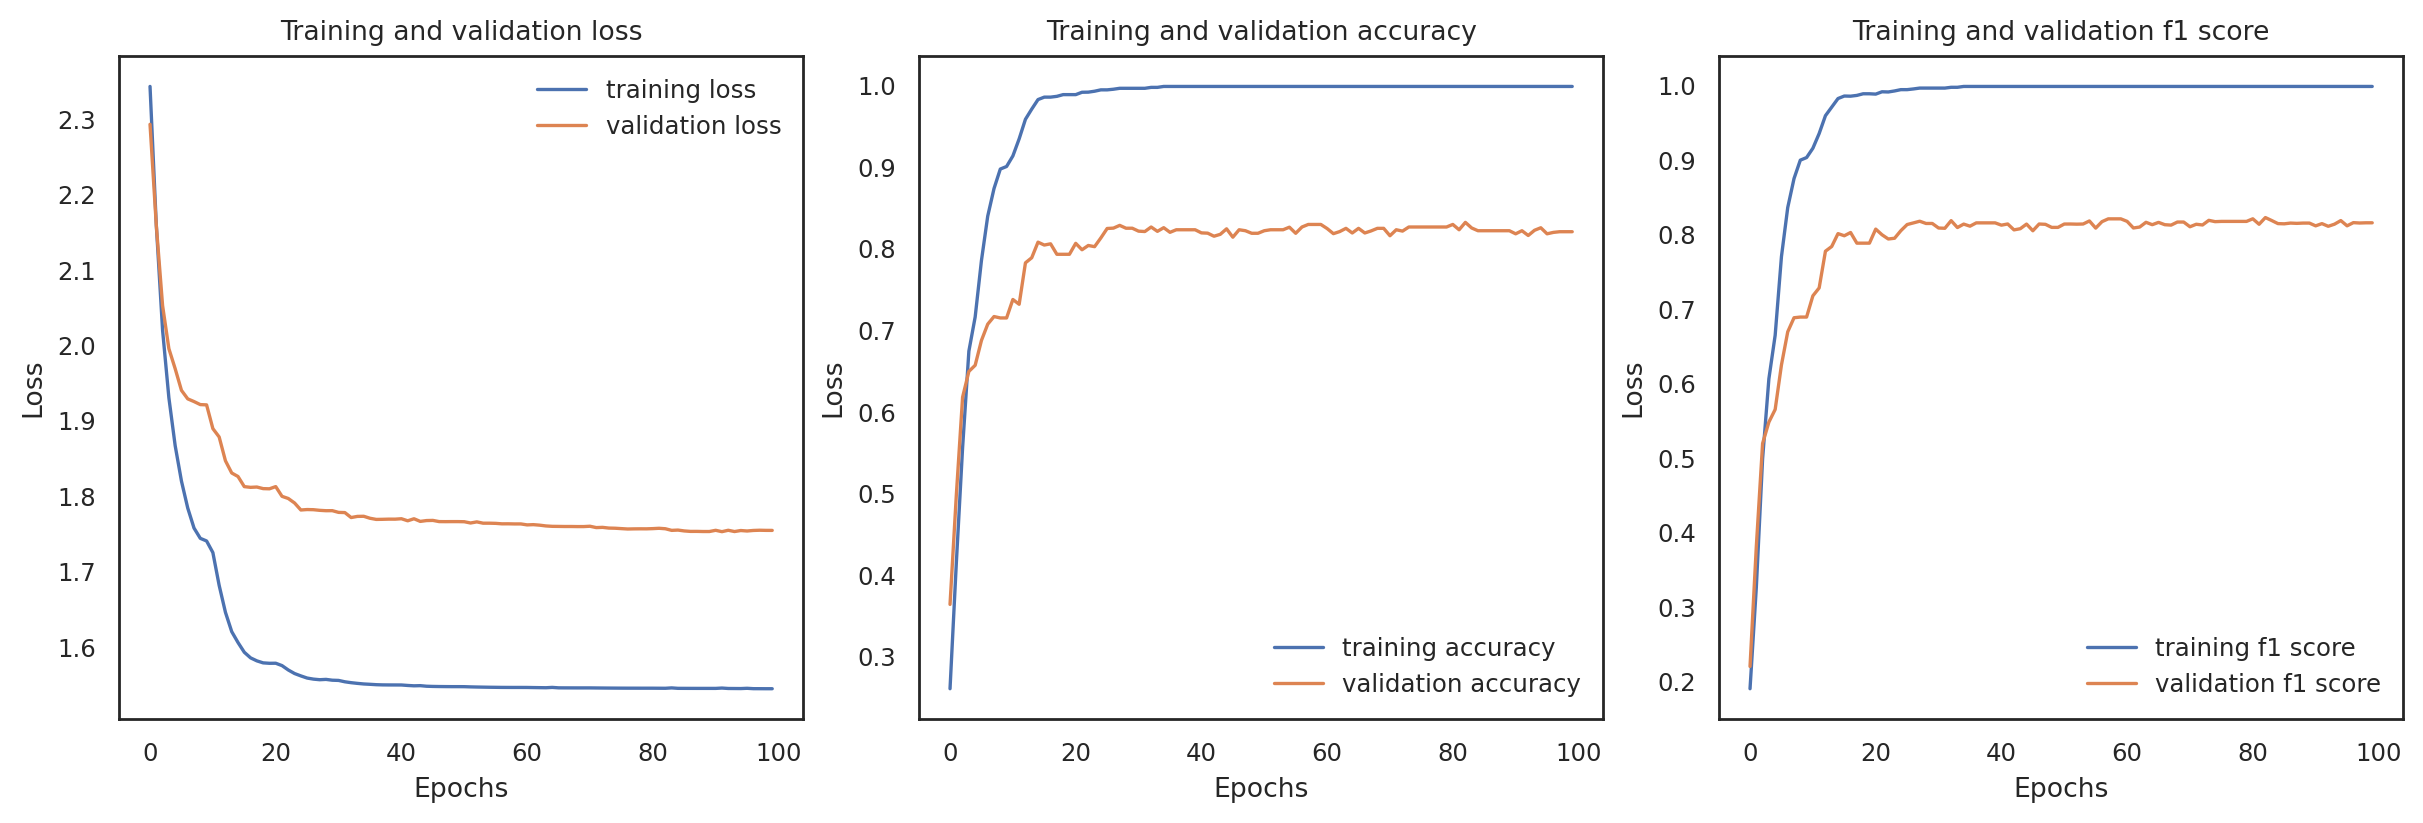

In [36]:
# You: Plot the training and validation loss
# visualize the loss as the network trained
fig, ax = plt.subplots(1, 3, figsize=[12, 4], layout='constrained')

ax[0].plot(range(epoch + 1), history['train_loss'], label='training loss')
ax[0].plot(range(epoch + 1), history['valid_loss'], label='validation loss')
ax[0].set(xlabel='Epochs', ylabel='Loss', title='Training and validation loss')

ax[1].plot(range(epoch + 1), history['train_acc'], label='training accuracy')
ax[1].plot(range(epoch + 1), history['valid_acc'], label='validation accuracy')
ax[1].set(xlabel='Epochs', ylabel='Loss', title='Training and validation accuracy')

ax[2].plot(range(epoch + 1), history['train_f1'], label='training f1 score')
ax[2].plot(range(epoch + 1), history['valid_f1'], label='validation f1 score')
ax[2].set(xlabel='Epochs', ylabel='Loss', title='Training and validation f1 score')

[ax[ii].legend(frameon=False) for ii in range(3)];

## See a sample video prediction

ic| idx: 65


Classified as ['swing'], corresponding to class ID 6
Reference is ['swing'], corresponding to class ID 6



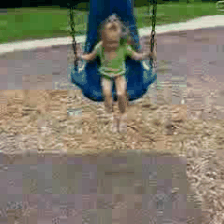

In [37]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    return embed.embed_file('./animation.gif')


idx = np.random.randint(0, test_features.shape[0]) # For good results, you can try IDs 348, 72
ic(idx)

sample_video = load_video(video_paths_test[idx])[:100]

# Make prediction on sample test video
prediction = model(test_features[idx].unsqueeze(0).cuda())
prediction = np.squeeze(prediction)
prediction = prediction.cpu().detach().numpy().argmax(axis=0)

# ic(prediction.shape)
# ic(prediction.argmax(axis=0))
# ic(test_labels[idx])
classes=['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding',
       'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping',
       'volleyball_spiking', 'walking']


print(f"Classified as {le.inverse_transform(np.array([prediction]))}, corresponding to class ID {prediction}")
print(f"Reference is {le.inverse_transform(np.array([test_labels[idx]]))}, corresponding to class ID {test_labels[idx]}")

# Display sample test video
to_gif(sample_video)

## Calculate test metrics

Overall accuracy: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

Average F1-Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [38]:
@torch.no_grad()
def eval_fn(model, dataloader):
    
    model.eval()

    y_pred = torch.tensor([], device=device)
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, preds = torch.max(outputs, dim=1)
        y_pred = torch.cat([y_pred, preds], dim=0)
        
    return y_pred.detach().cpu()


In [39]:
%%time

y_pred = eval_fn(model, test_loader)

  0%|          | 0/332 [00:00<?, ?it/s]

CPU times: user 209 ms, sys: 2 ms, total: 211 ms
Wall time: 209 ms


In [40]:
%%time
# You: Calculate test metrics
# Hint: Reference is in the variable "test_labels"

test_acc = accuracy_score(test_labels, y_pred)
test_f1 = f1_score(test_labels, y_pred, average='macro')

print(f'Testing accuracy: {test_acc:.5f} and f1 score: {test_f1:.5f}\n')

Testing accuracy: 0.83434 and f1 score: 0.82738

CPU times: user 5.93 ms, sys: 0 ns, total: 5.93 ms
Wall time: 6.81 ms


In [41]:
print(classification_report(test_labels, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

        basketball       0.67      0.85      0.75        33
            biking       0.94      0.91      0.92        33
            diving       1.00      0.87      0.93        30
        golf_swing       0.79      0.79      0.79        34
      horse_riding       0.94      0.90      0.92        50
   soccer_juggling       0.75      0.64      0.69        33
             swing       0.96      1.00      0.98        25
      tennis_swing       0.89      0.80      0.84        30
trampoline_jumping       0.76      0.59      0.67        22
volleyball_spiking       0.68      0.85      0.76        20
           walking       0.78      0.95      0.86        22

          accuracy                           0.83       332
         macro avg       0.83      0.83      0.83       332
      weighted avg       0.84      0.83      0.83       332



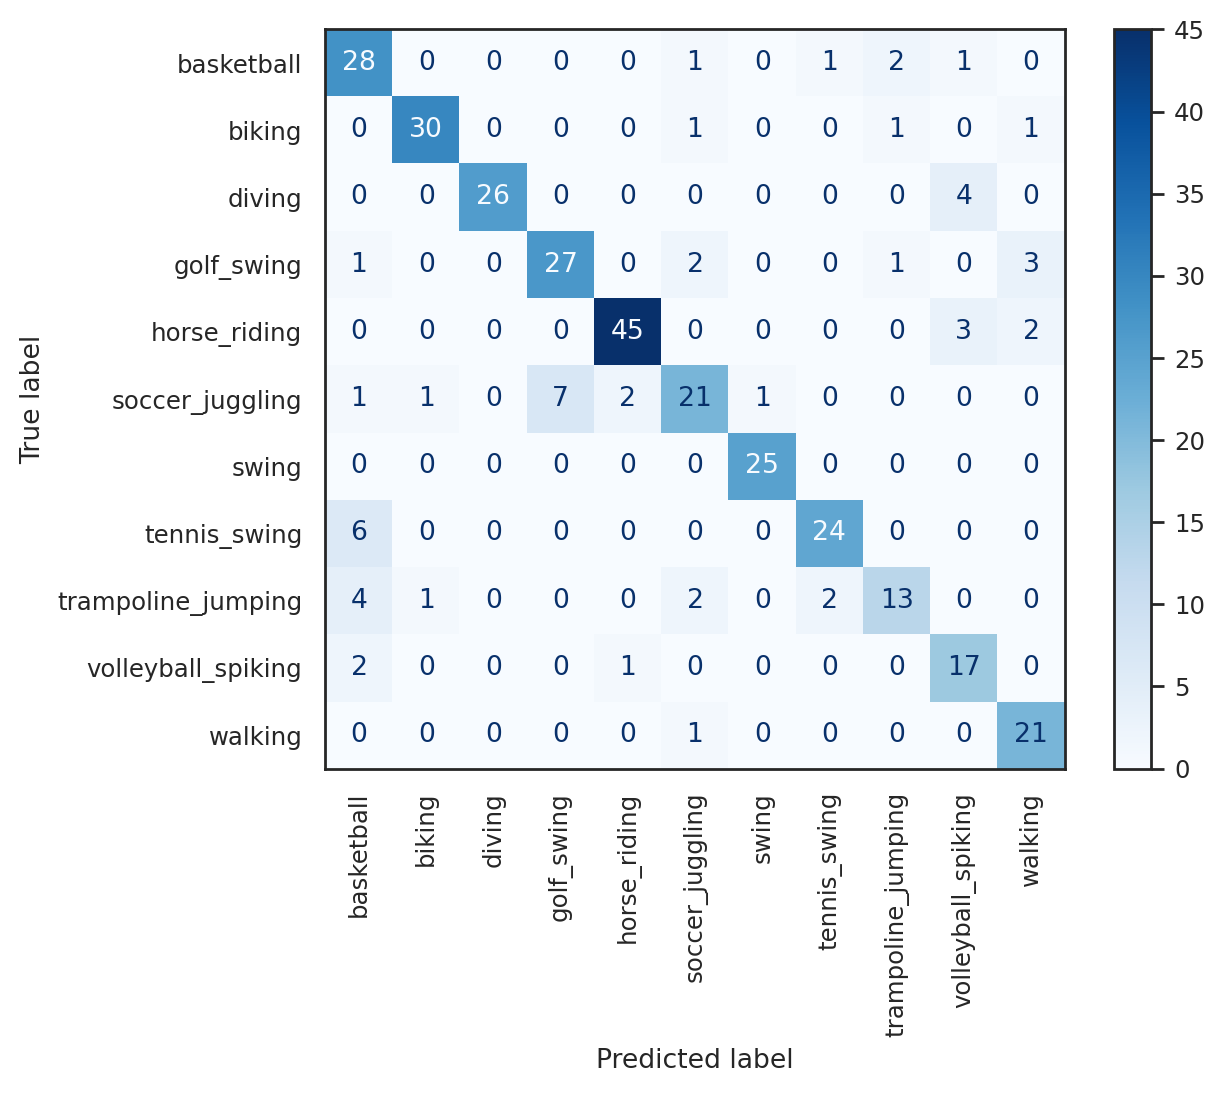

In [42]:
_ = ConfusionMatrixDisplay.from_predictions(
    test_labels, y_pred, cmap='Blues', display_labels=target_names, xticks_rotation='vertical'
)